In [6]:
import pandas as pd
import numpy as np

# 데이터 로드
df = pd.read_csv('./H-farm_data_20240328_20241214.csv')

# 기본 정보 확인
print("원본 데이터 정보:")
df.info()
print("\n결측치 개수:")
print(df.isnull().sum())


원본 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381985 entries, 0 to 381984
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   381985 non-null  object 
 1   T_out      379132 non-null  float64
 2   RH_out     379130 non-null  float64
 3   u_vent     378441 non-null  float64
 4   I_glob     378441 non-null  float64
 5   T_air_GT   336866 non-null  float64
 6   RH_air_GT  336866 non-null  float64
dtypes: float64(6), object(1)
memory usage: 20.4+ MB

결측치 개수:
datetime         0
T_out         2853
RH_out        2855
u_vent        3544
I_glob        3544
T_air_GT     45119
RH_air_GT    45119
dtype: int64


In [7]:
# datetime 컬럼을 datetime 타입으로 변환 (시간 순서를 고려한 보간을 위해)
df['datetime'] = pd.to_datetime(df['datetime'])

# 데이터를 datetime 기준으로 정렬 (보간의 정확성을 위해)
df = df.sort_values('datetime').reset_index(drop=True)

# 수치형 컬럼들 정의 (datetime 제외)
numeric_columns = ['T_out', 'RH_out', 'u_vent', 'I_glob', 'T_air_GT', 'RH_air_GT']


In [8]:
# 방법 1: 기본 선형보간 (인덱스 기반)
df_interpolated = df.copy()
df_interpolated[numeric_columns] = df_interpolated[numeric_columns].interpolate(method='linear')

print("기본 선형보간 후 결측치 개수:")
print(df_interpolated.isnull().sum())


기본 선형보간 후 결측치 개수:
datetime     0
T_out        0
RH_out       0
u_vent       0
I_glob       0
T_air_GT     1
RH_air_GT    1
dtype: int64


In [9]:
# 방법 2: 시간 기반 선형보간 (더 정확한 방법)
df_time_based = df.copy()
df_time_based = df_time_based.set_index('datetime')  # datetime을 인덱스로 설정
df_time_based[numeric_columns] = df_time_based[numeric_columns].interpolate(method='time')
df_time_based = df_time_based.reset_index()  # 인덱스를 다시 컬럼으로 변환

print("시간 기반 보간 후 결측치 개수:")
print(df_time_based.isnull().sum())


시간 기반 보간 후 결측치 개수:
datetime     0
T_out        0
RH_out       0
u_vent       0
I_glob       0
T_air_GT     1
RH_air_GT    1
dtype: int64


In [10]:
# 결과 비교 및 확인
print("\n보간 전 통계:")
print(df[numeric_columns].describe())
print("\n기본 선형보간 후 통계:")
print(df_interpolated[numeric_columns].describe())
print("\n시간 기반 보간 후 통계:")
print(df_time_based[numeric_columns].describe())

# 첫 번째와 마지막 값이 결측인 경우 처리 (선형보간으로 처리되지 않는 경우)
print("\n보간 후에도 남은 결측치 위치 확인:")
print("첫 번째 결측치:", df_interpolated.isnull().any(axis=1).idxmax() if df_interpolated.isnull().any().any() else "없음")
print("마지막 결측치:", df_interpolated.isnull().any(axis=1)[::-1].idxmax() if df_interpolated.isnull().any().any() else "없음")



보간 전 통계:
               T_out         RH_out         u_vent         I_glob  \
count  379132.000000  379130.000000  378441.000000  378441.000000   
mean       16.840560      80.943997       2.001730     149.372328   
std         6.815113      18.778820      13.515636     266.406790   
min        -7.000000       0.000000       0.000000       0.000000   
25%        13.100000      71.900002       0.000000       0.000000   
50%        16.799999      88.400002       0.800000       0.000000   
75%        21.799999      95.099998       2.300000     187.000000   
max        36.500000     100.000000     931.000000    1193.000000   

            T_air_GT      RH_air_GT  
count  336866.000000  336866.000000  
mean       24.226937      86.294028  
std        21.668785      36.031559  
min       -11.700000       0.000000  
25%        16.330000      73.199997  
50%        20.740000      85.810000  
75%        25.280000      93.699997  
max        99.900002     359.000000  

기본 선형보간 후 통계:
           

In [12]:
# 첫 번째/마지막 결측치까지 완전히 처리하는 방법
df_complete = df_time_based.copy()

# 방법 3: 앞쪽 결측치는 앞 방향 채우기(forward fill), 뒤쪽 결측치는 뒤 방향 채우기(backward fill)
df_complete[numeric_columns] = df_complete[numeric_columns].fillna(method='bfill').fillna(method='ffill')

# 또는 더 현대적인 방법 (pandas 2.0+)
# df_complete[numeric_columns] = df_complete[numeric_columns].bfill().ffill()

print("완전 보간 후 결측치 개수:")
print(df_complete.isnull().sum())

# 최종 데이터프레임 저장 (원하는 경우)
df_complete.to_csv('./H-farm_data_interpolated.csv', index=False)
print("\n보간 완료! 데이터가 준비되었습니다.")


C:\Users\malle\AppData\Local\Temp\ipykernel_51776\2304281480.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_complete[numeric_columns] = df_complete[numeric_columns].fillna(method='bfill').fillna(method='ffill')


완전 보간 후 결측치 개수:
datetime     0
T_out        0
RH_out       0
u_vent       0
I_glob       0
T_air_GT     0
RH_air_GT    0
dtype: int64

보간 완료! 데이터가 준비되었습니다.


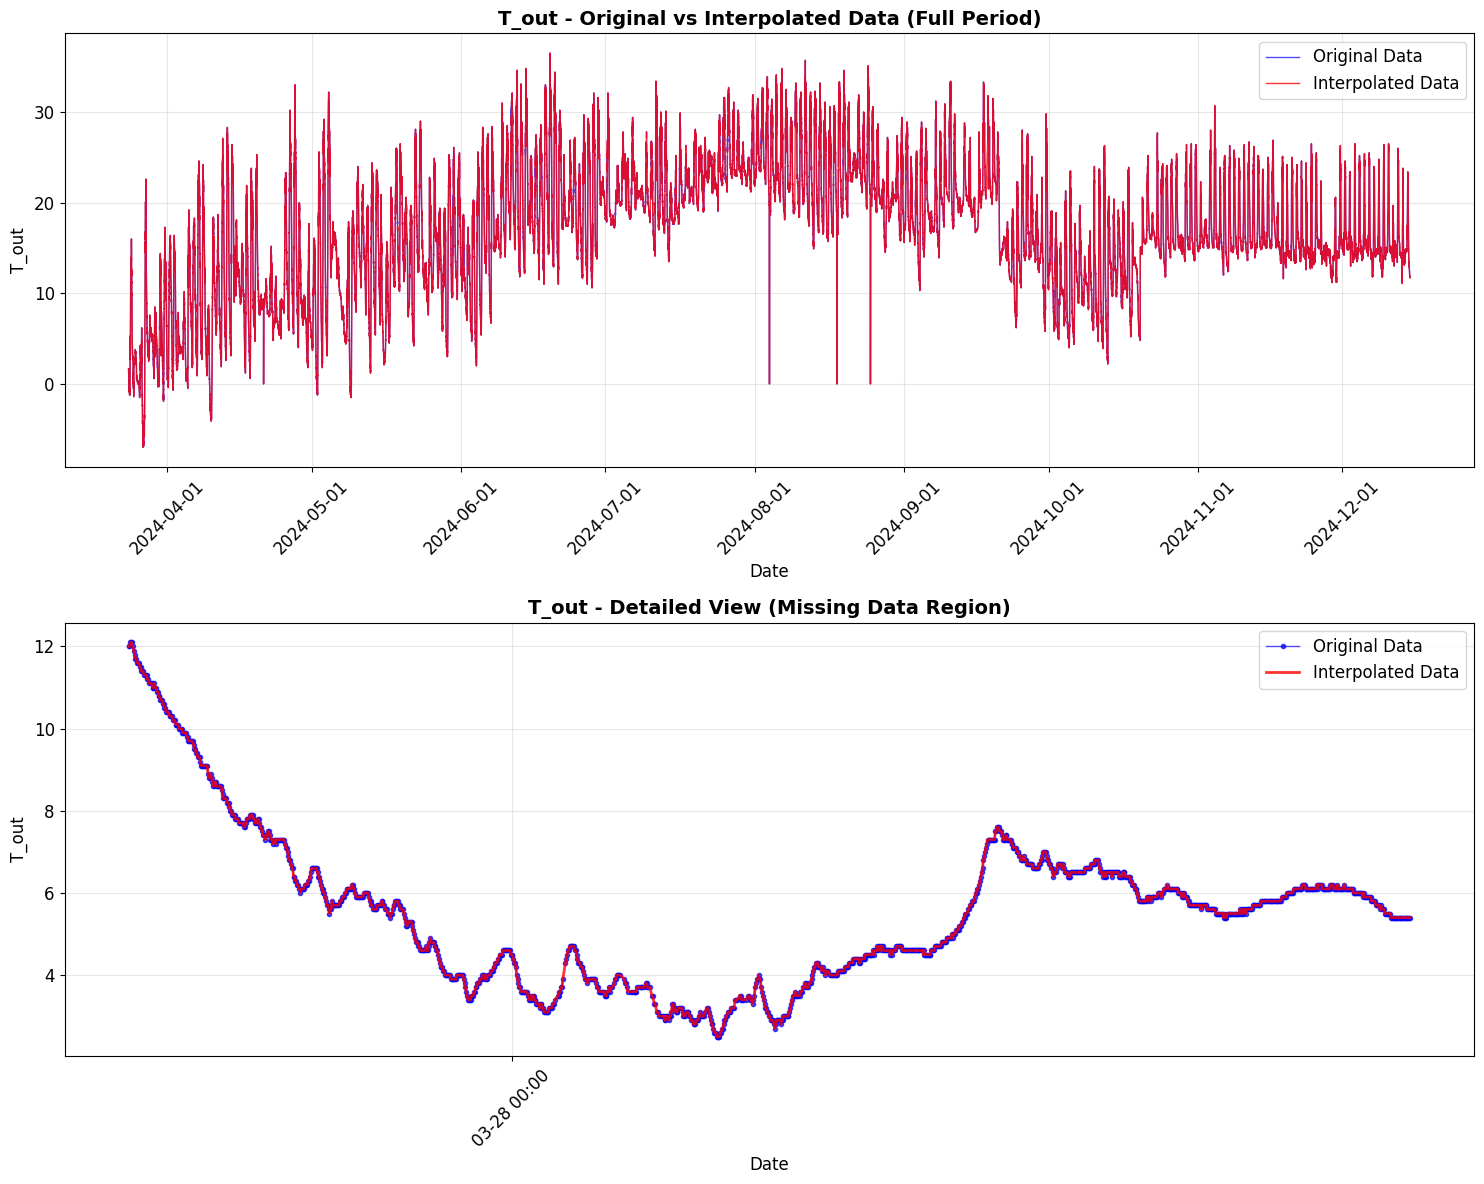


=== T_out 컬럼 보간 결과 ===
원본 데이터 결측치 개수: 2853
보간 후 결측치 개수: 0
보간된 값의 개수: 2853


In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# 시각화를 위한 설정
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

# T_out 컬럼 (첫 번째 수치 컬럼)을 기준으로 시각화
column_to_plot = 'T_out'

# 전체 데이터 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 상단 그래프: 전체 기간 데이터
ax1.plot(df['datetime'], df[column_to_plot], 'b-', alpha=0.7, label='Original Data', linewidth=1)
ax1.plot(df_time_based['datetime'], df_time_based[column_to_plot], 'r-', alpha=0.8, label='Interpolated Data', linewidth=1)
ax1.set_title(f'{column_to_plot} - Original vs Interpolated Data (Full Period)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel(f'{column_to_plot}', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# x축 날짜 형식 설정
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 하단 그래프: 결측치가 많은 구간 확대 (예시로 중간 부분)
# 결측치 위치 확인하여 적절한 구간 선택
missing_indices = df[df[column_to_plot].isnull()].index
if len(missing_indices) > 0:
    # 결측치 주변 구간 선택 (결측치 시작점 기준으로 ±500 포인트)
    start_idx = max(0, missing_indices[0] - 500)
    end_idx = min(len(df), missing_indices[0] + 1000)
else:
    # 결측치가 없으면 전체의 중간 구간 선택
    start_idx = len(df) // 3
    end_idx = start_idx + 2000

# 확대 구간 데이터
zoom_df_orig = df.iloc[start_idx:end_idx]
zoom_df_interp = df_time_based.iloc[start_idx:end_idx]

ax2.plot(zoom_df_orig['datetime'], zoom_df_orig[column_to_plot], 'bo-', alpha=0.7, 
         label='Original Data', markersize=3, linewidth=1)
ax2.plot(zoom_df_interp['datetime'], zoom_df_interp[column_to_plot], 'r-', alpha=0.8, 
         label='Interpolated Data', linewidth=2)
ax2.set_title(f'{column_to_plot} - Detailed View (Missing Data Region)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel(f'{column_to_plot}', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# x축 날짜 형식 설정 (더 세밀하게)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 결측치 통계 출력
print(f"\n=== {column_to_plot} 컬럼 보간 결과 ===")
print(f"원본 데이터 결측치 개수: {df[column_to_plot].isnull().sum()}")
print(f"보간 후 결측치 개수: {df_time_based[column_to_plot].isnull().sum()}")
print(f"보간된 값의 개수: {df[column_to_plot].isnull().sum() - df_time_based[column_to_plot].isnull().sum()}")


In [1]:
import pandas as pd

In [5]:
import pandas as pd

df = pd.read_csv('./H-farm_data_20240328_20241214.csv')

df.head()

df.columns

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381985 entries, 0 to 381984
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   381985 non-null  object 
 1   T_out      379132 non-null  float64
 2   RH_out     379130 non-null  float64
 3   u_vent     378441 non-null  float64
 4   I_glob     378441 non-null  float64
 5   T_air_GT   336866 non-null  float64
 6   RH_air_GT  336866 non-null  float64
dtypes: float64(6), object(1)
memory usage: 20.4+ MB


,T_out,RH_out,u_vent,I_glob,T_air_GT,RH_air_GT
count,379132.000000,379130.000000,378441.000000,378441.000000,336866.000000,336866.000000
mean,16.840560,80.943997,2.001730,149.372328,24.226937,86.294028
std,6.815113,18.778820,13.515636,266.406790,21.668785,36.031559
min,-7.000000,0.000000,0.000000,0.000000,-11.700000,0.000000
25%,13.100000,71.900002,0.000000,0.000000,16.330000,73.199997
50%,16.799999,88.400002,0.800000,0.000000,20.740000,85.810000
75%,21.799999,95.099998,2.300000,187.000000,25.280000,93.699997
max,36.500000,100.000000,931.000000,1193.000000,99.900002,359.000000
